## BOLFI convergence

This notebook discusses how to examine BOLFI convergence and model fit. This is not intended to be a real tutorial but to show some new plots that could help to assess convergence and diagnose problems!

In [1]:
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%precision 2

import logging
logging.basicConfig(level=logging.INFO)

# Set an arbitrary global seed to keep the randomly generated quantities the same
seed = 1
np.random.seed(seed)

import elfi

### Example

Load MA2 example:

In [2]:
from elfi.examples import ma2
model = ma2.get_model(seed_obs=seed)

Transform discrepancies as proposed in the [tutorial](https://elfi.readthedocs.io/en/latest/usage/BOLFI.html):

In [3]:
log_d = elfi.Operation(np.log, model['d'])

Run BOLFI:

In [4]:
bounds = {'t1':(-2, 2), 't2':(-1, 1)}

Here we use `save_params=True` to record target model hyperparameter values.

In [5]:
bolfi = elfi.BOLFI(log_d, bounds=bounds, batch_size=1, initial_evidence=20, acq_noise_var=0.1, update_interval=10, seed=seed, save_params=True)

Let us acquire 100 evidence points as proposed in the tutorial.

In [6]:
%time post = bolfi.fit(n_evidence=100)

INFO:elfi.methods.inference.bolfi:BOLFI: Fitting the surrogate model...


Progress [==================================================] 100.0% Complete


INFO:elfi.methods.posteriors:Using optimized minimum value (-1.6966) of the GP discrepancy mean function as a threshold


CPU times: user 51.4 s, sys: 4.01 s, total: 55.5 s
Wall time: 1min 40s


### Convergence and model fit

- parameter history

The target model hyperparameter values are recorded in `bolfi.params_hist` and can be plotted to assess convergence:

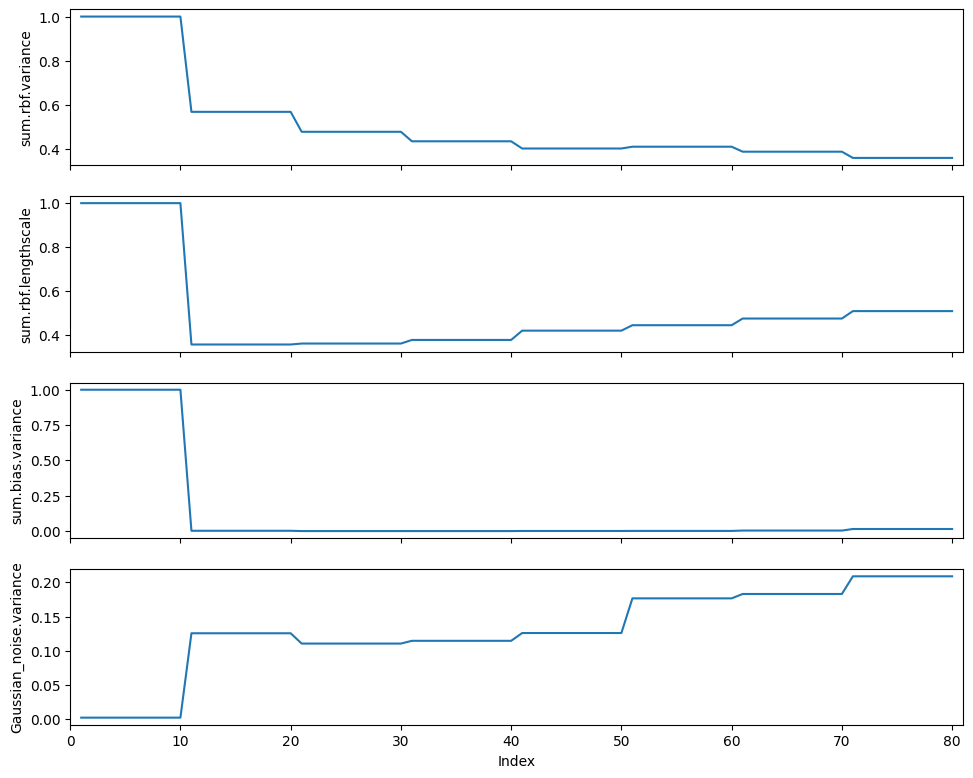

In [7]:
bolfi.plot_params_hist();

The hyperparameters were also updated in the last iteration but the new values are close to the last recorded value:

In [8]:
bolfi.params_hist[-1]  # last hyperparameter values that have been used to decide on acquisitions

array([0.36, 0.51, 0.02, 0.21])

In [9]:
bolfi.target_model.param_array  # updated hyperparameter values that would be used to decide on the next acquisition

array([0.35, 0.51, 0.02, 0.2 ])

While it is not possible to know whether some new data could lead the model to update the hyperparameters more, it appears that the model has found at least a local optimum.

- acquisitions

The tutorial notebook advices to plot the BOLFI state and discrepancies see how BOLFI has explored the parameter space:

<Figure size 640x480 with 0 Axes>

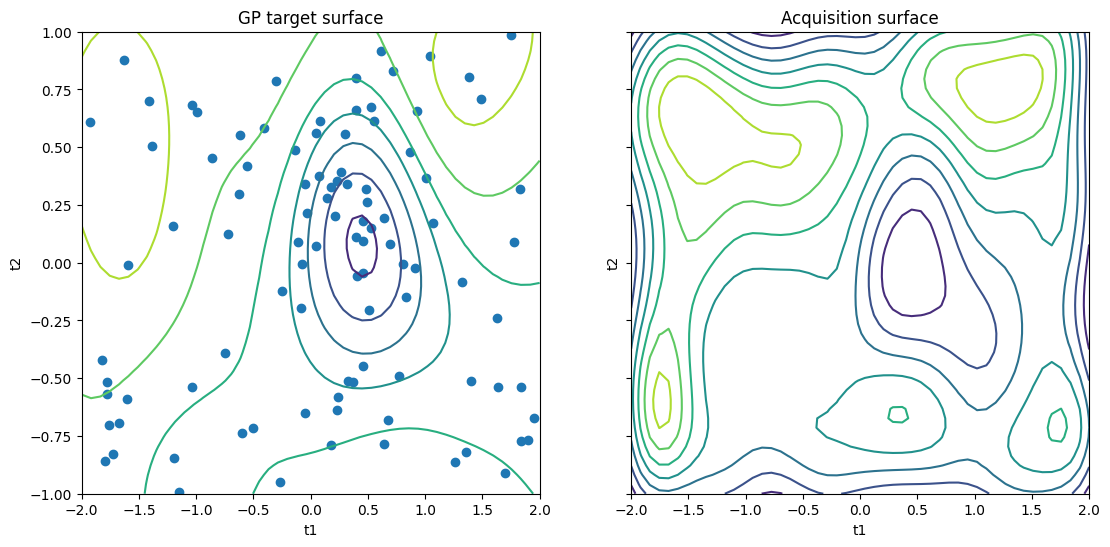

In [10]:
bolfi.plot_state();

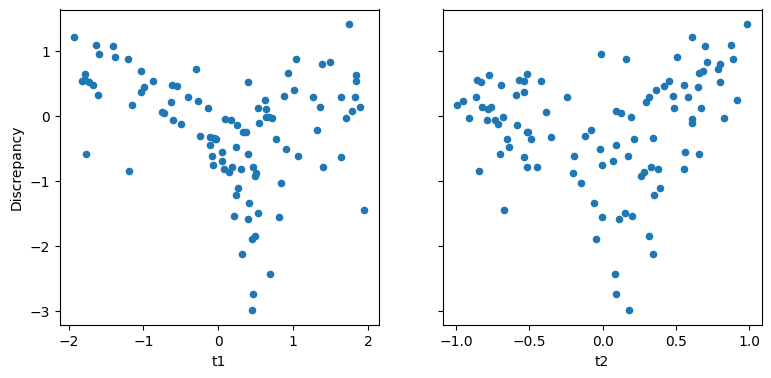

In [11]:
bolfi.plot_discrepancy(s=20);

The same data can be plotted in acquisition order to see whether BOLFI has focussed the search on certain parameter values or continues to explore. Here the shaded area indicates the initialisation data:

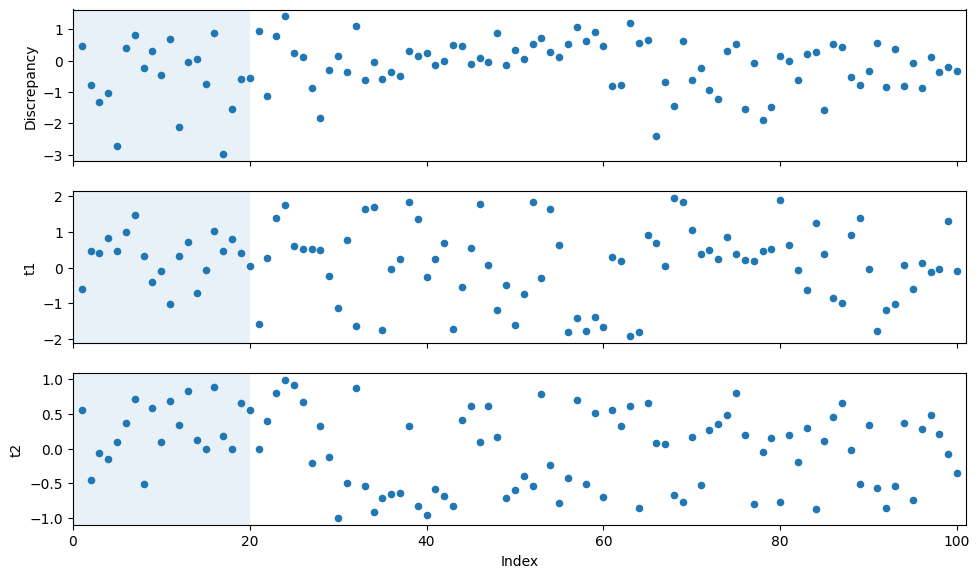

In [12]:
bolfi.plot_evidence_hist(s=20);

We can add the current predicted minimum as reference.

In [13]:
res = bolfi.extract_result()
res.x_min

{'t1': array([0.45]), 't2': array([0.07])}

In [14]:
pred_min = bolfi.target_model.predict([res.x_min[param] for param in model.parameter_names])[0]
pred_min

array([[-1.7]])

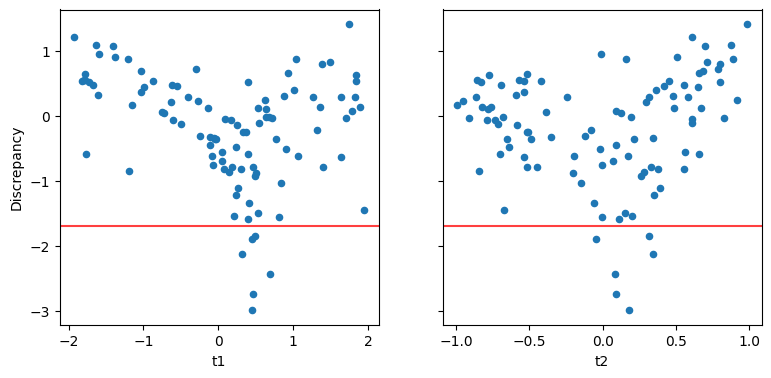

In [15]:
bolfi.plot_discrepancy(s=20, reference_y=pred_min);  # can also add reference_x

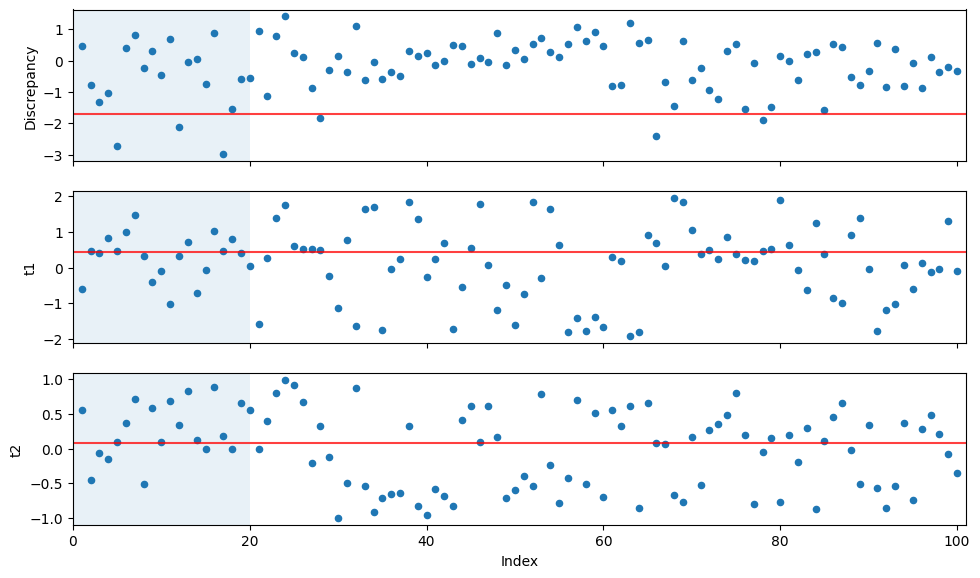

In [16]:
bolfi.plot_evidence_hist(s=20, reference_x=res.x_min, reference_y=pred_min);

While it is not possible to know whether the current predicted minimum is correct or not, we can see whether it was sampled in the recent iterations and whether BOLFI has explored around it.

- prediction errors

We can see based on the acquisition results that BOLFI has been able to find parameter values that produce small discrepancies. If this had not been the case, we could examine whether there is a problem with the model fit.

If possible, we should evaluate the model fit over some validation data.

In [17]:
test = model.generate(100, seed=seed)

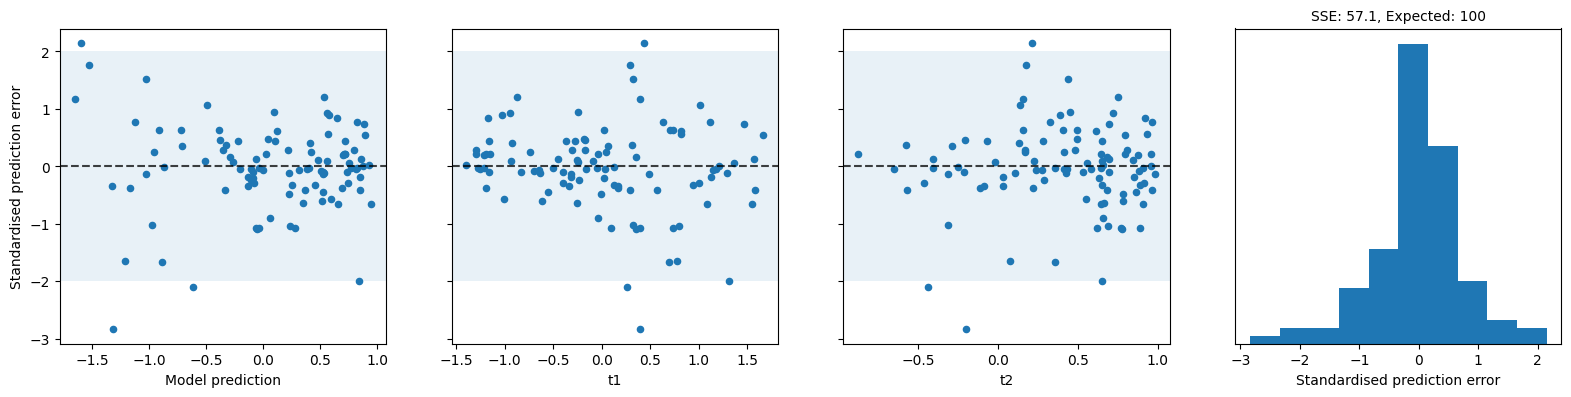

In [18]:
bolfi.plot_gp_error(data=(test, test['log_d']), s=20, bins=10);

The standardised prediction errors should follow a t-distribution with `df = n_evidence` and so should be approximately normally distributed around zero (dashed line). Most (around 95%) errors should be within two standard deviations from zero (shaded area) and there should be no dependencies between the error distribution and the model predictions or parameter values. Moreover the sum over squared errors (SSE) should be close to the validation dataset size.

If it would be too expensive to sample new data for validation, one can examine leave-one-out errors instead:

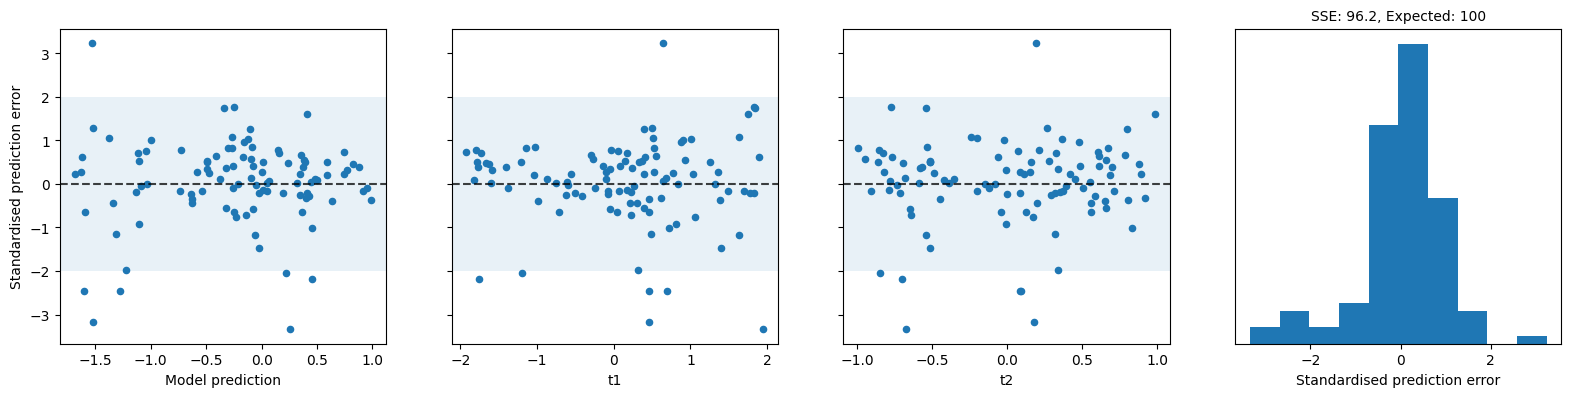

In [19]:
bolfi.plot_gp_error(s=20, bins=10);

Note that SSE calculated based on the leave-one-out errors is close to the expected value while SSE calculated based on the separate validation data indicated that the errors are too small and that the predictive variance is overestimated. Meanwhile can see based on either leave-one-out or validation errors that there are several extreme values and that the error variance does not appear to be constant wrt model predictions or parameters.

The model fit problems observed in the error plots could be due to non-stationarity or heteroscedastic noise. Since we have a fast simulator, we can compare observed discrepancies at two input locations to see whether we have a problem with heteroscedastic noise:

In [20]:
test_1 = model.generate(1000, with_values={'t1': -1, 't2': -0.5}, seed=seed)
test_2 = model.generate(1000, with_values={'t1': 0.5, 't2': 0.2}, seed=seed)

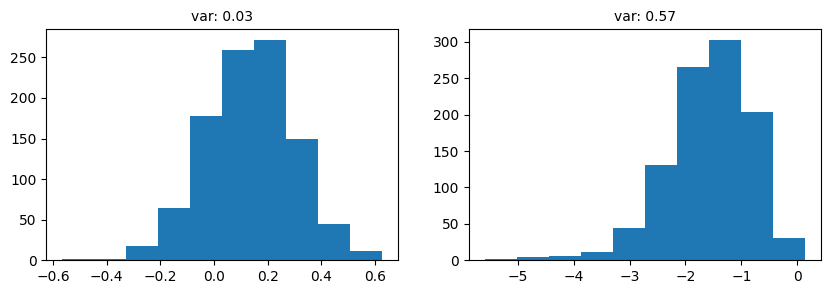

In [21]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(test_1['log_d'])
ax[0].set_title('var: {:.2f}'.format(np.var(test_1['log_d'])), size=10)
ax[1].hist(test_2['log_d'])
ax[1].set_title('var: {:.2f}'.format(np.var(test_2['log_d'])), size=10);

The difference between the variances confirms that the noise (random variation between discrepancies calculated at the same input parameters) is heteroscedastic. The noise also does not follow a normal distribution, which explains the extreme errors.

To summarise, we can see some problems with the model fit, but we could also see from the acquisition results that BOLFI was still able to use the model, and we will see next that the model can still provide a reasonable posterior estimate.

### Posterior

Let us sample the estimated posterior and examine the result.

In [22]:
%time result_BOLFI = bolfi.sample(1000, info_freq=1000)

INFO:elfi.methods.posteriors:Using optimized minimum value (-1.6966) of the GP discrepancy mean function as a threshold
INFO:elfi.methods.mcmc:NUTS: Performing 1000 iterations with 500 adaptation steps.
INFO:elfi.methods.mcmc:NUTS: Adaptation/warmup finished. Sampling...
INFO:elfi.methods.mcmc:NUTS: Acceptance ratio: 0.432. After warmup 50 proposals were outside of the region allowed by priors and rejected, decreasing acceptance ratio.
INFO:elfi.methods.mcmc:NUTS: Performing 1000 iterations with 500 adaptation steps.
INFO:elfi.methods.mcmc:NUTS: Adaptation/warmup finished. Sampling...
INFO:elfi.methods.mcmc:NUTS: Acceptance ratio: 0.420. After warmup 55 proposals were outside of the region allowed by priors and rejected, decreasing acceptance ratio.
INFO:elfi.methods.mcmc:NUTS: Performing 1000 iterations with 500 adaptation steps.
INFO:elfi.methods.mcmc:NUTS: Adaptation/warmup finished. Sampling...
INFO:elfi.methods.mcmc:NUTS: Acceptance ratio: 0.434. After warmup 50 proposals were out

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
t1 1790.5804891701903 1.0005904979350149
t2 2095.327920291841 0.9997294531716089
CPU times: user 2min 50s, sys: 24.3 s, total: 3min 14s
Wall time: 4min 14s


In [23]:
result_BOLFI

Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: -1.7
Parameter                Mean               2.5%              97.5%
t1:                     0.442              0.067              0.819
t2:                     0.059             -0.303              0.415


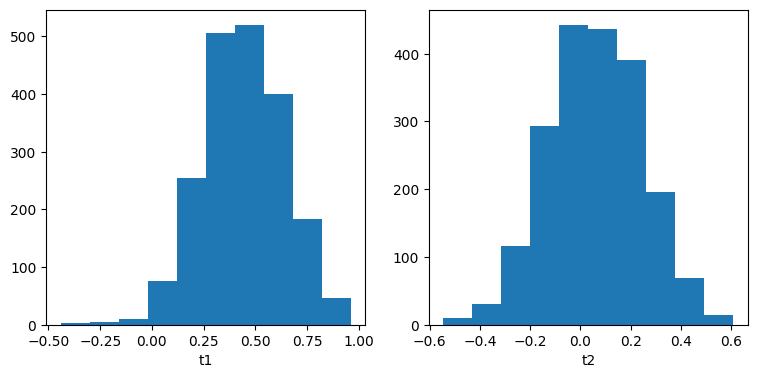

In [24]:
result_BOLFI.plot_marginals(bins=10);

We would need to compare to a reference posterior to know whether these are accurate, but for now let's just use the posterior predictive distribution to check that the posterior concords with the observed data.

In [25]:
post_pred = model.generate(with_values = result_BOLFI.samples, seed=seed)

Here we compare the observed and predicted summaries.

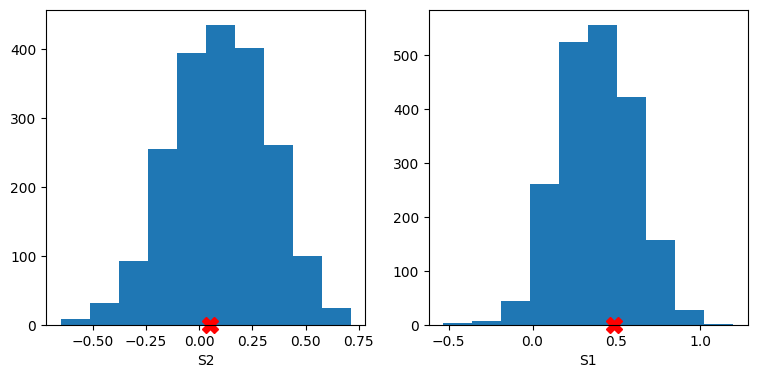

In [26]:
elfi.visualization.visualization.plot_marginals(post_pred, selector=['S1', 'S2'], reference_value = {name: model[name].observed for name in ['S1', 'S2']}, bins=10);

We can see that the posterior predictive distributions for the summaries are concentrated around the observed values and are much narrower than the prior predictive distributions which would have looked like this:

In [27]:
prior_pred = model.generate(2000, seed=seed)

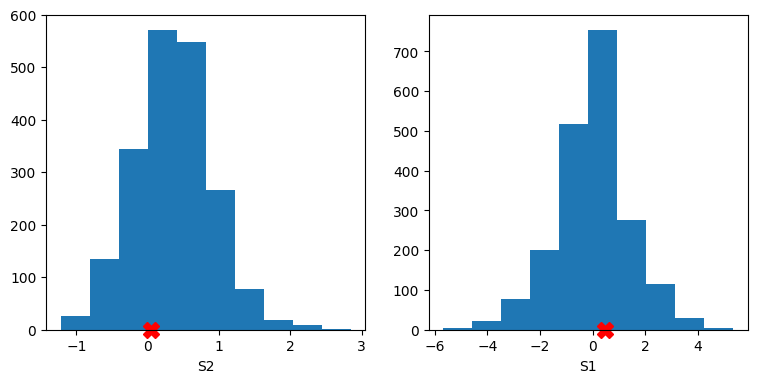

In [28]:
elfi.visualization.visualization.plot_marginals(prior_pred, selector=['S1', 'S2'], reference_value = {name: model[name].observed for name in ['S1', 'S2']}, bins=10);